In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

2022-06-08 07:46:44.942127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 07:46:44.942377: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data=pd.read_csv('../raw_data/age_gender.csv')

In [3]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

for j in range(len(data)):
    data['pixels'][j]=data['pixels'][j]/255

/tmp/ipykernel_31716/2643723236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pixels'][j]=data['pixels'][j]/255


In [4]:
data = data.drop(data[data.age<5].index).copy()
data = data.drop(data[data.age>80].index).copy()

data.reset_index(drop=True)

,age,ethnicity,gender,img_name,pixels
0,10,0,0,20170110225414790.jpg.chip.jpg,"[0.11764706, 0.14901961, 0.19607843, 0.3529412..."
1,10,0,0,20170110225417177.jpg.chip.jpg,"[0.28235295, 0.31764707, 0.36862746, 0.3764706..."
2,10,0,0,20170110224549512.jpg.chip.jpg,"[1.0, 0.99215686, 0.9882353, 0.8666667, 0.5647..."
3,10,0,0,20170110225402690.jpg.chip.jpg,"[0.24313726, 0.20784314, 0.21568628, 0.2431372..."
4,10,0,0,20170110225421531.jpg.chip.jpg,"[0.10980392, 0.23529412, 0.21568628, 0.2156862..."
...,...,...,...,...,...
20993,9,0,0,20170110215653284.jpg.chip.jpg,"[0.28627452, 0.25882354, 0.30588236, 0.4235294..."
20994,9,0,0,20170110215848132.jpg.chip.jpg,"[0.2901961, 0.34901962, 0.2, 0.24705882, 0.270..."
20995,9,0,0,20170110220005370.jpg.chip.jpg,"[0.38431373, 0.3529412, 0.3529412, 0.43529412,..."
20996,9,0,0,20170110220016235.jpg.chip.jpg,"[0.22352941, 0.2901961, 0.3647059, 0.36078432,..."


In [6]:
data5_24=data[data.age<=24]
data40_80=data[data.age>=40]
data25_39=data[data.age>=25]
data25_39=data25_39[data25_39.age<40]

In [9]:
def age_class(age):
    if age<=24: return 0
    if age<=39: return 1
    return 2

In [10]:
data['age_class']=data['age'].apply(age_class)

In [11]:
### perform one-hot encoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
ohe.fit(data[['age_class']])
class_age_encoded = ohe.transform(data[['age_class']])


for elements in range(class_age_encoded.shape[1]):      # =====> THIS IS NEED WHATHERVER HOT ENCODER USED  <=====
    data[str(elements)]=class_age_encoded[:,elements]

In [12]:
data.head(5)

,age,ethnicity,gender,img_name,pixels,age_class,0,1,2
1123,10,0,0,20170110225414790.jpg.chip.jpg,"[0.11764706, 0.14901961, 0.19607843, 0.3529412...",0,1.0,0.0,0.0
1124,10,0,0,20170110225417177.jpg.chip.jpg,"[0.28235295, 0.31764707, 0.36862746, 0.3764706...",0,1.0,0.0,0.0
1125,10,0,0,20170110224549512.jpg.chip.jpg,"[1.0, 0.99215686, 0.9882353, 0.8666667, 0.5647...",0,1.0,0.0,0.0
1126,10,0,0,20170110225402690.jpg.chip.jpg,"[0.24313726, 0.20784314, 0.21568628, 0.2431372...",0,1.0,0.0,0.0
1127,10,0,0,20170110225421531.jpg.chip.jpg,"[0.10980392, 0.23529412, 0.21568628, 0.2156862...",0,1.0,0.0,0.0


In [14]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y=data.drop(columns=['age','ethnicity','gender', 'pixels', 'age_class', 'img_name'])

X_train, X_test_age, y_train, y_test_age = train_test_split(X, y, test_size=0.3, random_state=3)

In [15]:
def initialize_model_catgorical(numb_int, numb_out):
        
    model = Sequential()
    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu',input_shape=(48,48,numb_int)))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    # model.add(layers.Conv2D(320,(3,3), padding='same',activation='relu'))
    # model.add(layers.Conv2D(320,(3,3), padding='same',activation='relu'))
    model.add(layers.Conv2D(320,(3,3), padding='same',activation='relu'))


    # model.add(layers.Conv2D(520,(3,3), padding='same',activation='relu'))
    # model.add(layers.Conv2D(520,(3,3), padding='same',activation='relu'))
    # model.add(layers.Conv2D(520,(3,3), padding='same',activation='relu'))
    # model.add(layers.Conv2D(520,(3,3), padding='same',activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dropout(0.2))    
    model.add(layers.Dense(numb_out, activation='softmax'))   
    return model

In [16]:
model_cat = initialize_model_catgorical(X.shape[-1], y.shape[-1])
    
es = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

model_cat.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

history_cat = model_cat.fit(X_train,y_train, validation_split=0.2, epochs=50, callbacks=[es])

2022-06-08 07:56:10.281624: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-08 07:56:10.282470: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-RM2V0FMT): /proc/driver/nvidia/version does not exist
2022-06-08 07:56:10.300149: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 07:56:10.750557: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 108361728 exceeds 10% of free system memory.


Epoch 1/50
  1/368 [..............................] - ETA: 17:57 - loss: 1.1109 - accuracy: 0.0938

2022-06-08 07:56:15.651366: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18911232 exceeds 10% of free system memory.
2022-06-08 07:56:15.651582: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18911232 exceeds 10% of free system memory.
2022-06-08 07:56:15.666595: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27205632 exceeds 10% of free system memory.
2022-06-08 07:56:15.666972: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27205632 exceeds 10% of free system memory.


368/368 [==============================] - 25s 60ms/step - loss: 1.0394 - accuracy: 0.4787 - val_loss: 0.9751 - val_accuracy: 0.5354
Epoch 2/50
368/368 [==============================] - 20s 55ms/step - loss: 0.9087 - accuracy: 0.5601 - val_loss: 0.8564 - val_accuracy: 0.5891
Epoch 3/50
368/368 [==============================] - 20s 54ms/step - loss: 0.8412 - accuracy: 0.6013 - val_loss: 0.8473 - val_accuracy: 0.6129
Epoch 4/50
368/368 [==============================] - 19s 53ms/step - loss: 0.7930 - accuracy: 0.6376 - val_loss: 0.7901 - val_accuracy: 0.6320
Epoch 5/50
368/368 [==============================] - 20s 55ms/step - loss: 0.7585 - accuracy: 0.6521 - val_loss: 0.7560 - val_accuracy: 0.6429
Epoch 6/50
368/368 [==============================] - 21s 56ms/step - loss: 0.7332 - accuracy: 0.6681 - val_loss: 0.7709 - val_accuracy: 0.6381
Epoch 7/50
368/368 [==============================] - 20s 54ms/step - loss: 0.7012 - accuracy: 0.6775 - val_loss: 0.7322 - val_accuracy: 0.6670
Epo

In [17]:
import joblib
joblib.dump(model_cat, '../raw_data/age_model_cat.joblib')

2022-06-08 08:02:52.874951: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://108b6857-e78d-4d72-ba7e-c02164c3b79f/assets


['../raw_data/age_model_cat.joblib']

# Linear

In [20]:
def initialize_model_regression():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))         

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

In [22]:
y=data['age']

X_train, X_test_age, y_train, y_test_age = train_test_split(X, y, test_size=0.3, random_state=3)

In [23]:
# initialize the model
model = initialize_model_regression()

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# early stopping
es = EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)


# fit
history = model.fit(X_train, y_train, validation_split=0.3, epochs=100, callbacks=[es])

Epoch 1/100
322/322 [==============================] - 24s 69ms/step - loss: 280.2323 - mae: 12.9080 - val_loss: 721.9318 - val_mae: 22.4802
Epoch 2/100
322/322 [==============================] - 22s 67ms/step - loss: 188.2402 - mae: 10.5796 - val_loss: 274.0139 - val_mae: 12.9321
Epoch 3/100
322/322 [==============================] - 21s 66ms/step - loss: 158.3643 - mae: 9.7066 - val_loss: 107.6143 - val_mae: 8.0617
Epoch 4/100
322/322 [==============================] - 21s 65ms/step - loss: 146.7679 - mae: 9.3403 - val_loss: 177.3819 - val_mae: 10.3000
Epoch 5/100
322/322 [==============================] - 21s 66ms/step - loss: 135.3073 - mae: 8.9313 - val_loss: 107.9918 - val_mae: 7.9836
Epoch 6/100
322/322 [==============================] - 21s 65ms/step - loss: 126.3632 - mae: 8.5930 - val_loss: 94.5281 - val_mae: 7.5583
Epoch 7/100
322/322 [==============================] - 21s 67ms/step - loss: 116.6671 - mae: 8.2697 - val_loss: 96.5973 - val_mae: 7.6493
Epoch 8/100
322/322 [===

In [31]:
import cv2

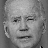

In [72]:
from PIL import Image
image=Image.open('../raw_data/Other images/joe.jpg')

new_size=(48,48)

image = np.array(image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(image=image,scaleFactor=1.3, minNeighbors=3, minSize=(30, 30))
output_faces=[]

for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0),1)
    output_image = image[y:y + h, x:x + w]
    output_faces.append(f"{x}-{y}-{w}-{h}")

image=cv2.resize(output_image, dsize=new_size, interpolation=cv2.INTER_CUBIC)

image=np.mean(image, axis=2)

image=Image.fromarray(np.uint8(image), 'L')

image = image.resize(new_size)

array=np.array(image.getdata()).reshape((-1, 48,48,1))

array=array/255

image

In [73]:
model.predict(array)

array([[52.690838]], dtype=float32)

In [74]:
model_cat.predict(array)

array([[0.60013044, 0.3419605 , 0.05790902]], dtype=float32)

# Ethnicity

In [ ]:
model_eth=joblib.load('../model')